In [97]:
NUM_IMGS = 16
BATCH_SIZE = 4
NUM_CHANNELS = 3
IMAGE_SIZE = (32, 32)
KEY_SIZE = (8, 8)

DS_INDEX = 429

LEARNING_RATE = 1e-4

import math
NROW = int(math.sqrt(BATCH_SIZE))

In [98]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

from IPython.display import clear_output

format = transforms.Compose([
    transforms.CenterCrop((400, 400)),
    transforms.Resize(IMAGE_SIZE, transforms.InterpolationMode.LANCZOS),
    transforms.ToTensor(),
])

ds = datasets.Flowers102(root='../pytorch-datasets/', split='train', transform=format, download=True)
ds = torch.utils.data.Subset(ds, torch.randint(0, len(ds), (NUM_IMGS,)))
dl = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

len(ds), len(dl)

(16, 4)

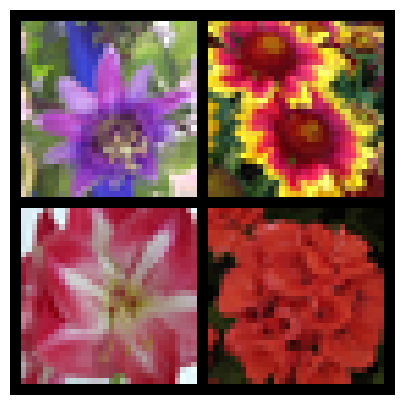

In [99]:
assert math.sqrt(BATCH_SIZE).is_integer(), 'Batch size must have an integer square root'
for b, l in dl:
    plt.figure(figsize=(5, 5))
    plt.imshow(make_grid(b, nrow=NROW).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    break

data = b

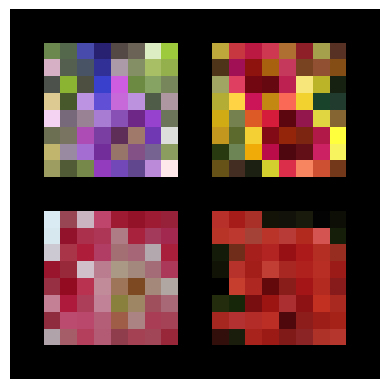

In [100]:
key = F.interpolate(data, size=KEY_SIZE, mode='nearest')

plt.imshow(make_grid(key, nrow=NROW).permute(1, 2, 0))
plt.axis('off')
plt.show()

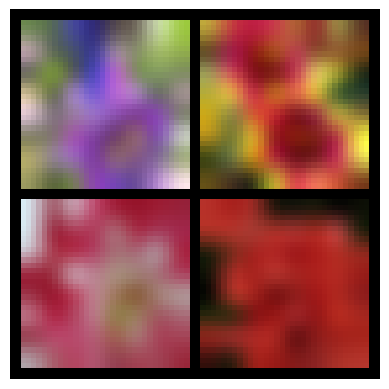

In [101]:
PAD_SIZE = 3

def make_basis(key, std=2, pad_size=PAD_SIZE):
    basis = F.interpolate(key, size=IMAGE_SIZE, mode='nearest')
    x = torch.arange(-pad_size, pad_size+1).float()
    sig2 = std*std * 2

    kernel = torch.exp(-x**2 / sig2) / math.sqrt(2*math.pi)
    kernel = torch.outer(kernel, kernel)
    kernel = kernel / kernel.sum()
    kernel = kernel[None, None, :, :].repeat(3, 1, 1, 1)

    basis = F.pad(basis, (pad_size, pad_size, pad_size, pad_size), mode='reflect')
    basis = F.conv2d(basis, kernel, groups=3, padding=0, stride=1)
    return basis

basis = make_basis(key)

plt.imshow(make_grid(basis.cpu(), nrow=2).permute(1, 2, 0))
plt.axis('off')
plt.show()

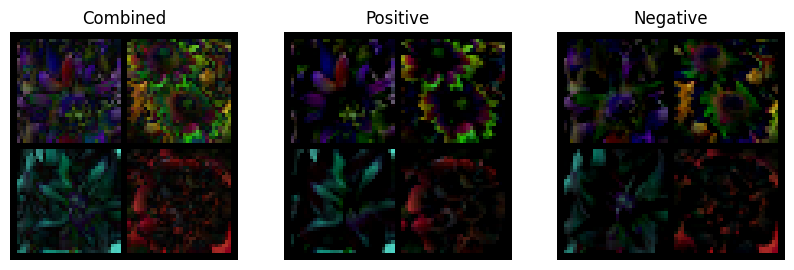

In [102]:
target = data - basis

target_abs = torch.clamp(torch.abs(target), 0, 1)
target_pos = torch.clamp(target, 0, 1)
target_neg = torch.clamp(-target, 0, 1)

save_image(target_abs, 'target.png')

ax, fig = plt.subplots(1, 3, figsize=(10, 3))
fig[0].set_title('Combined')
fig[0].imshow(make_grid(target_abs, nrow=2).permute(1, 2, 0).numpy())
fig[0].axis('off')
fig[1].set_title('Positive')
fig[1].imshow(make_grid(target_pos, nrow=2).permute(1, 2, 0).numpy())
fig[1].axis('off')
fig[2].set_title('Negative')
fig[2].imshow(make_grid(target_neg, nrow=2).permute(1, 2, 0).numpy())
fig[2].axis('off')
plt.show()

In [110]:
class SineActivation(nn.Module):
    def __init__(self):
        super(SineActivation, self).__init__()

    def forward(self, x):
        return torch.sin(x)


class Learner(nn.Module):
    def __init__(self, key_size):
        super(Learner, self).__init__()
        self.key_size = key_size
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'), # 8 -> 16
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 6, kernel_size=3),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(1),
            nn.Conv2d(6, 12, kernel_size=3),
            nn.ReLU(inplace=True),

            nn.Flatten(1),
            nn.Linear(12*16*16, 24*16*16),
            SineActivation(),
            nn.Linear(24*16*16, 48*16*16),
            SineActivation(),
            nn.Unflatten(1, (48, 16, 16)),

            nn.Upsample(scale_factor=2, mode='nearest'), # 16 -> 32
            nn.ReflectionPad2d(2),
            nn.Conv2d(48, 12, kernel_size=5),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(4),
            nn.Conv2d(12, 3, kernel_size=9),
        )

    def forward(self, x):
        y = self.decoder(x)
        return y

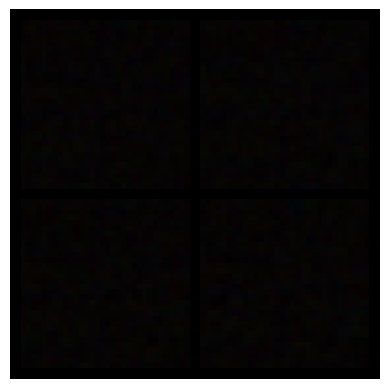

torch.Size([4, 3, 32, 32])

In [111]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Learner(KEY_SIZE).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
losses = []

with torch.no_grad():
    pred = torch.clamp(torch.abs(model(key.to(device))), 0, 1)
    plt.imshow(make_grid(pred, nrow=2).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

pred.shape

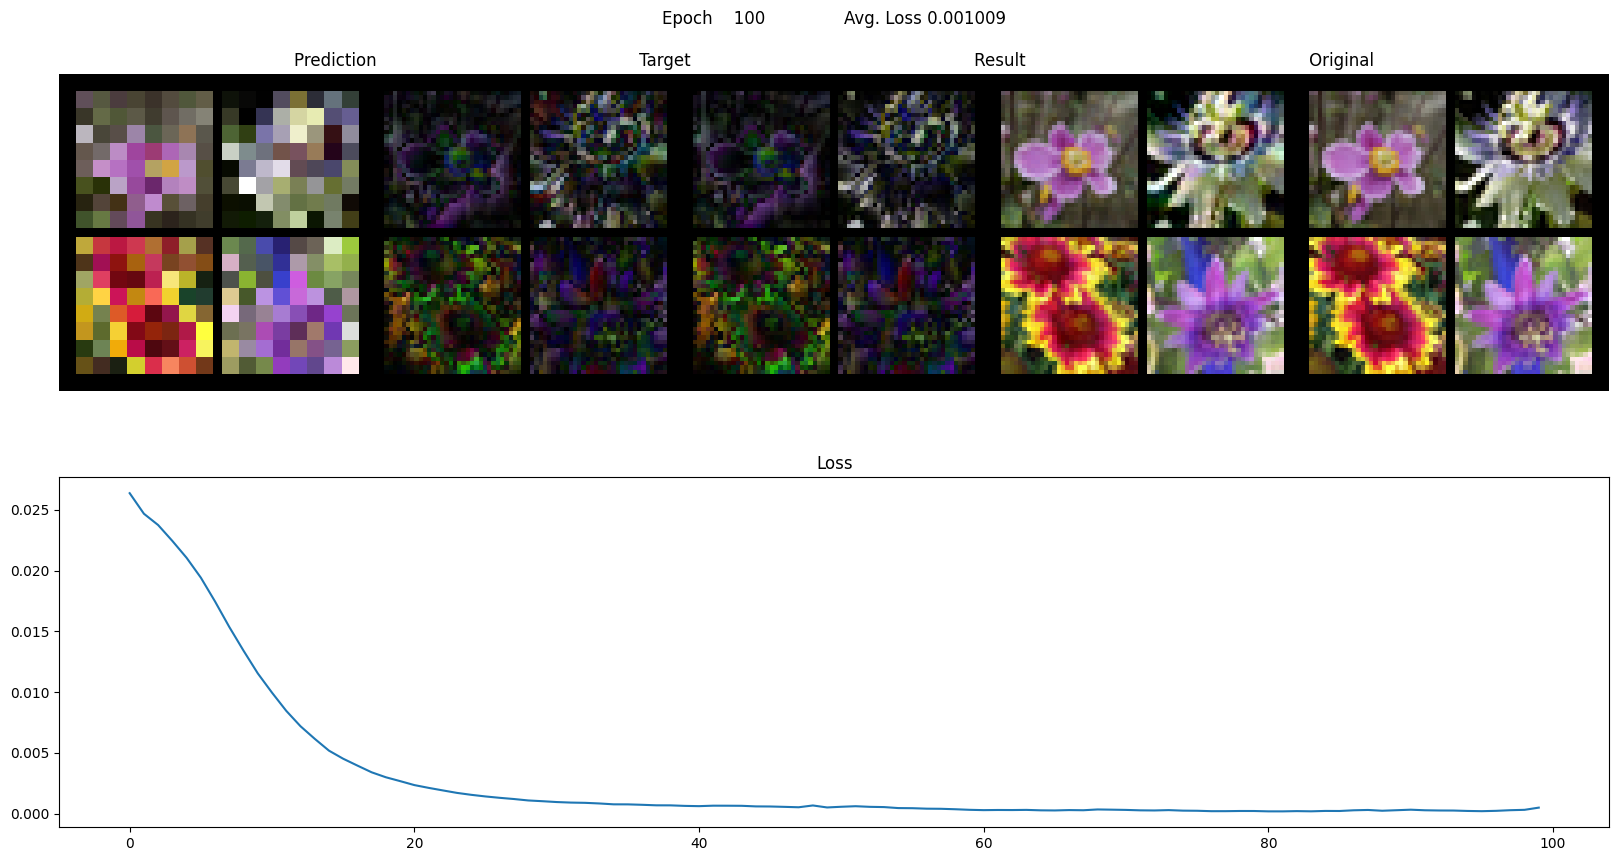

In [ ]:
EPOCHS = 40

model.train()
torch.set_grad_enabled(True)

for epoch in range(1, EPOCHS+1):
    epoch_loss = 0
    
    for batch, _ in dl:
        key = F.interpolate(batch, size=KEY_SIZE, mode='nearest')
        basis = make_basis(key).to(device)
        key = key.to(device)
        batch = batch.to(device)
        target = batch - basis

        pred = model(key)
        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    losses.append(epoch_loss / len(dl))

    if epoch == 1 or epoch % 10 == 0:
        with torch.no_grad():
            result = torch.clamp(basis.to(device) + pred, 0, 1)
            pred = torch.clamp(torch.abs(pred), 0, 1)

        clear_output(wait=True)

        ax, fig = plt.subplots(2, 1, figsize=(20, 10))
        out = make_grid(torch.stack([
                make_grid(F.interpolate(key, (32, 32), mode='nearest'), nrow=NROW).cpu(),
                make_grid(pred, nrow=NROW).cpu(),
                make_grid(torch.abs(target), nrow=NROW).cpu(),
                make_grid(result, nrow=NROW).cpu(),
                make_grid(batch, nrow=NROW).cpu(),
            ], 0), nrow=5)

        fig[0].set_title(f'Epoch {str(epoch).rjust(6).ljust(20)} Avg. Loss {loss.item():6f}\n\n{"Prediction".ljust(60)}{"Target".ljust(60)}{"Result".ljust(60)}Original')
        fig[0].imshow(out.permute(1, 2, 0))
        fig[0].axis('off')

        fig[1].set_title('Loss')
        fig[1].plot(losses)

        plt.show()